Libraries imported successfully.

--- Loading and Preparing Data ---
Training data size: 4457 messages
Testing data size: 1115 messages

--- Building an Advanced Model Pipeline ---

--- Searching for the Best Hyperparameters with GridSearchCV ---
This may take a few minutes...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

GridSearchCV complete. Time taken: 3.11 seconds.

Best parameters found:
{'classifier__C': 10, 'vectorizer__max_df': 0.95, 'vectorizer__ngram_range': (1, 2)}

Best cross-validation accuracy: 0.9886

--- Evaluating the Final Tuned Model Performance ---
Final Model Accuracy on Test Set: 0.9874 (98.74%)

Confusion Matrix:


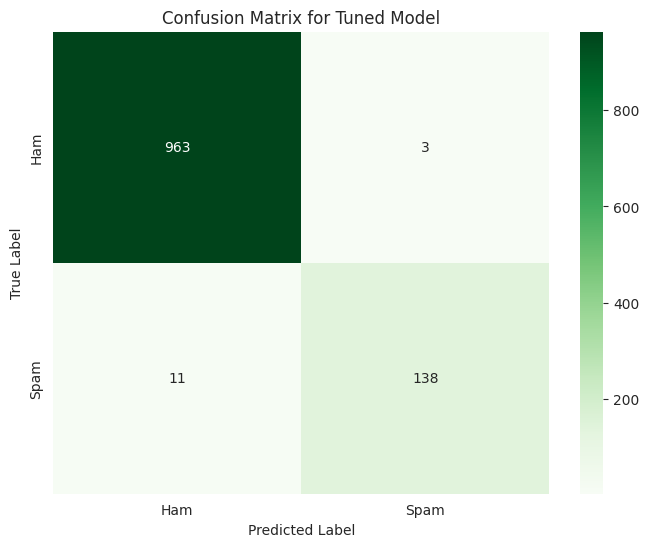


Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       966
        Spam       0.98      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115


--- Generating ROC Curve and AUC Score ---
Area Under ROC Curve (AUC): 0.9885


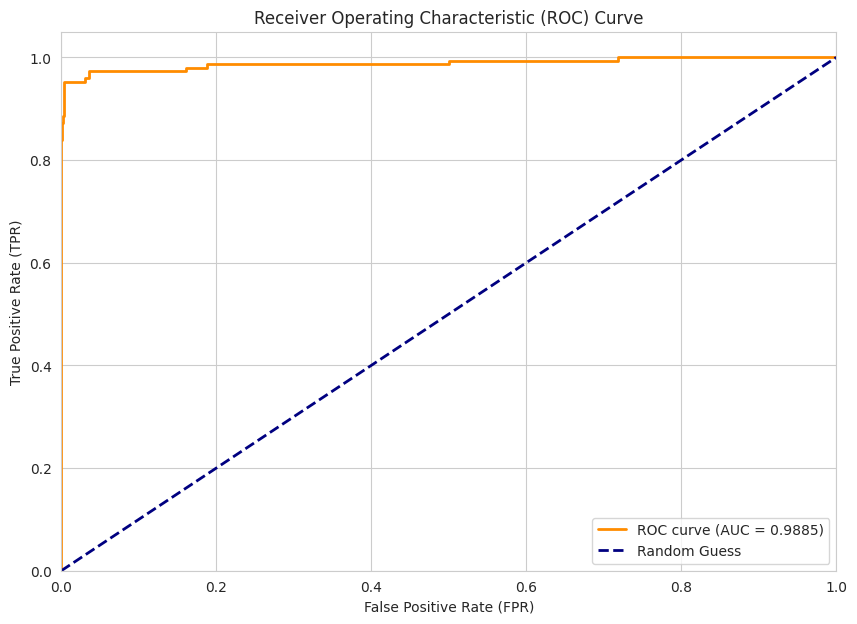


--- Making Predictions with the Final, Highly Accurate Model ---

Message: 'Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.'
Prediction: Spam
----------------------------------------

Message: 'Hey, are you available for our meeting tomorrow at 2 PM? Let me know.'
Prediction: Ham
----------------------------------------

Message: 'URGENT: Your account has been flagged for unusual activity. Please verify your details immediately at www.fakebank-security-check.com'
Prediction: Spam
----------------------------------------

Message: 'Can you pick up some milk on your way home? Thanks!'
Prediction: Ham
----------------------------------------

Message: 'free money call now'
Prediction: Spam
----------------------------------------


In [3]:
# =============================================================================
# Step 1: Import Necessary Libraries
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

print("Libraries imported successfully.")


# =============================================================================
# Step 2: Load and Prepare the Data (Identical to before)
# =============================================================================
print("\n--- Loading and Preparing Data ---")

# URL of the dataset
url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
messages = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# Define features (X) and target (y)
X = messages['message']
y = messages['label'].map({'ham': 0, 'spam': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data size: {len(X_train)} messages")
print(f"Testing data size: {len(X_test)} messages")


# =============================================================================
# Step 3: Build a More Advanced Pipeline
# =============================================================================
print("\n--- Building an Advanced Model Pipeline ---")

advanced_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC(random_state=42, dual=True)) # dual=True is often recommended for n_samples > n_features
])


# =============================================================================
# Step 4: Hyperparameter Tuning with GridSearchCV
# =============================================================================
print("\n--- Searching for the Best Hyperparameters with GridSearchCV ---")
print("This may take a few minutes...")

parameters = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)], # Unigrams or Bigrams
    'vectorizer__max_df': [0.95],               # Ignore terms that are too frequent
    'classifier__C': [1, 10]                    # Regularization parameter
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=advanced_pipeline,
    param_grid=parameters,
    cv=5,
    n_jobs=-1,
    verbose=1 # Changed to 1 for a cleaner output
)

# Start the timer and fit the grid search to the training data.
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nGridSearchCV complete. Time taken: {end_time - start_time:.2f} seconds.")

print("\nBest parameters found:")
print(grid_search.best_params_)

print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# The `grid_search` object is now the best model
best_model = grid_search.best_estimator_


# =============================================================================
# Step 5: Evaluate the Final, Tuned Model
# =============================================================================
print("\n--- Evaluating the Final Tuned Model Performance ---")

# Make predictions for standard metrics
y_pred = best_model.predict(X_test)

# 1. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy on Test Set: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 2. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned Model')
plt.show()

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# 4. ROC Curve and AUC Score
print("\n--- Generating ROC Curve and AUC Score ---")
# Get the decision function scores for the positive class (spam)
# This gives a confidence score for each prediction
y_scores = best_model.decision_function(X_test)

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the Area Under the Curve (AUC)
roc_auc = roc_auc_score(y_test, y_scores)
print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")

# Plotting the ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# =============================================================================
# Step 6: Use the Final Model to Make Predictions
# =============================================================================
print("\n--- Making Predictions with the Final, Highly Accurate Model ---")

def predict_message_final(model, message):
    """Predicts using the final tuned model."""
    prediction = model.predict([message])
    label = "Spam" if prediction[0] == 1 else "Ham"

    print(f"\nMessage: '{message}'")
    print(f"Prediction: {label}")
    print("-" * 40)

# Test with some example messages
predict_message_final(best_model, "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.")
predict_message_final(best_model, "Hey, are you available for our meeting tomorrow at 2 PM? Let me know.")
predict_message_final(best_model, "URGENT: Your account has been flagged for unusual activity. Please verify your details immediately at www.fakebank-security-check.com")
predict_message_final(best_model, "Can you pick up some milk on your way home? Thanks!")
predict_message_final(best_model, "free money call now")